<a href="https://colab.research.google.com/github/heyraisin/AI-Challenge-1/blob/main/Challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/AI-Course/Challenge1

/content/gdrive/MyDrive/AI-Course/Challenge1


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import json

## **Getting Data**

**Loading Three Datasets**

In [ ]:
cake_URL = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cake.npy'
camera_URL = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/camera.npy'
candle_URL = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/candle.npy'

_URL = [cake_URL, camera_URL, candle_URL]

# list of name of files
dir_name = ['cake.npy', 'camera.npy', 'candle.npy']
npy_dir = []

for name, url in zip(dir_name,_URL):
    npy_dir.append(tf.keras.utils.get_file(name, cache_subdir='datasets/quickdraw',origin = url)) 
npy_dir

110985216/110971360 [==============================] - 2s 0us/step


['/root/.keras/datasets/quickdraw/cake.npy',
 '/root/.keras/datasets/quickdraw/camera.npy',
 '/root/.keras/datasets/quickdraw/candle.npy']

In [ ]:
max_items_per_class = 100000
num_val = 2000
# Declare the shape of X and y for training and testing
X = np.empty([0, 784])
y = np.empty([0])
# Declare the shape of X and y for validating
val_X = np.empty([0, 784])
val_y = np.empty([0])
# Load all the data
for i, file_path in enumerate(npy_dir):
    data = np.load(file_path)
    data_val = data[max_items_per_class:max_items_per_class+num_val, :]
    label_val = np.full(data_val.shape[0], i)

    data = data[0: max_items_per_class, :]
    labels = np.full(data.shape[0], i)

    X = np.concatenate((X, data), axis=0).astype('float32') #Convert to float32 to save memory
    y = np.append(y, labels)

    val_X = np.concatenate((val_X, data_val), axis = 0).astype('float32')
    val_y = np.append(val_y, label_val)

print(f'X shape: {X.shape}\ny shape: {y.shape}\nVal_X: {val_X.shape}\nVal_y: {val_y.shape}')

X shape: (300000, 784)
y shape: (300000,)
Val_X: (6000, 784)
Val_y: (6000,)


**Examine the Datasets**

In [ ]:
# load the data for image preview
cake = np.load(npy_dir[0])
camera = np.load(npy_dir[1])
candle = np.load(npy_dir[2])

In [ ]:
def plot_samples(input_array, rows=3, cols=10, title=''):
    '''
    Function to plot 28x28 pixel drawings that are stored in a numpy array.
    Specify how many rows and cols of pictures to display (default 4x5).  
    If the array contains less images than subplots selected, surplus subplots remain empty.
    '''
    
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

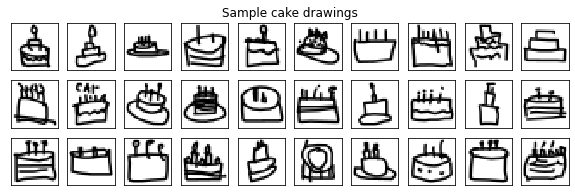

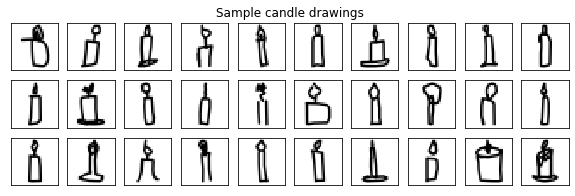

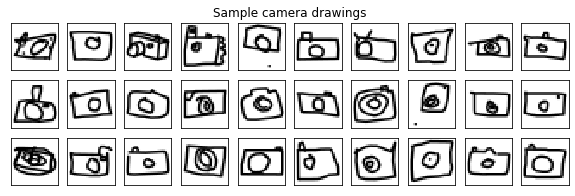

In [ ]:
plot_samples(cake, title = 'Sample cake drawings')
plot_samples(candle, title = 'Sample candle drawings')
plot_samples(camera, title = 'Sample camera drawings')

**Splitting Datasets into Training and Test Data - Shuffling Data**

In [ ]:
#Reshape X and val_X into (28,28)
X = np.reshape(X, (X.shape[0], 28,28))
val_X = np.reshape(val_X, (val_X.shape[0], 28,28))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X/255., y, test_size=0.3, random_state=42)

In [ ]:
X_train.shape, y_train.shape

((210000, 28, 28), (210000,))

In [ ]:
# Add a color dimension to the images in "train" and "validate" dataset to
# leverage Keras's data augmentation utilities later 
X_train = np.expand_dims(X_train, axis = 3)
X_test = np.expand_dims(X_test, axis = 3)

In [ ]:
X_train[0].shape

(28, 28, 1)

## **Building the Model**

**Creating a Sequential CNN Model**

In [ ]:
# one hot encode outputs
from keras.utils.np_utils import to_categorical
y_train_cnn = to_categorical(y_train)
y_test_cnn = to_categorical(y_test)
y_val_cnn = to_categorical(val_y)
num_classes = y_test_cnn.shape[1]

In [ ]:
num_classes

3

In [ ]:
X_train.shape

(210000, 28, 28, 1)

In [ ]:
# reshape to be 
X_train_cnn = X_train.reshape(X_train.shape[0], 28, 28,1).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 28, 28,1).astype('float32')
X_val_cnn = val_X.reshape(val_X.shape[0], 28, 28,1).astype('float32')

In [ ]:
image_shape = X_train_cnn.shape[1:]
image_shape

(28, 28, 1)

**Adding Layers to The Model**

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(28,28,1)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(28,28)),
        tf.keras.layers.Reshape((28,28,1)),
        tf.keras.layers.Conv2D(filters = 32, kernel_size=(5,5), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2,2), strides=2),
        tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu',padding='same'),
        tf.keras.layers.MaxPooling2D((2,2), strides=2),
        tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2,2), strides=2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

**Compiling the Model**

In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(optimizer = adam_optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)         

# **Training the Model**

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=4,
    monitor='val_accuracy',
    restore_best_weights=True,
    verbose=1
)

In [ ]:
%time 
history = model.fit(X_train_cnn, y_train_cnn, 
                    validation_data=(X_test_cnn, y_test_cnn), 
                    epochs= 40,
                    steps_per_epoch=400, 
                    callbacks=[
                        early_stopping_callback
                    ],
                    verbose = 1)
model.save('saved_model/quickdraw.h5')
print('Model Save Successfully')

CPU times: user 12 µs, sys: 4 µs, total: 16 µs
Wall time: 19.8 µs
Epoch 1/40
400/400 [==============================] - 35s 61ms/step - loss: 0.1046 - accuracy: 0.9615 - val_loss: 0.0610 - val_accuracy: 0.9777
Epoch 2/40
400/400 [==============================] - 21s 52ms/step - loss: 0.0597 - accuracy: 0.9786 - val_loss: 0.0556 - val_accuracy: 0.9802
Epoch 3/40
400/400 [==============================] - 32s 80ms/step - loss: 0.0523 - accuracy: 0.9809 - val_loss: 0.0486 - val_accuracy: 0.9821
Epoch 4/40
400/400 [==============================] - 21s 54ms/step - loss: 0.0473 - accuracy: 0.9825 - val_loss: 0.0499 - val_accuracy: 0.9820
Epoch 5/40
400/400 [==============================] - 20s 51ms/step - loss: 0.0432 - accuracy: 0.9843 - val_loss: 0.0454 - val_accuracy: 0.9836
Epoch 6/40
400/400 [==============================] - 19s 48ms/step - loss: 0.0410 - accuracy: 0.9848 - val_loss: 0.0449 - val_accuracy: 0.9836
Epoch 7/40
400/400 [==============================] - 21s 52ms/step - 

**Plotting Graphs of The Model Loss and Accuracy During Training**

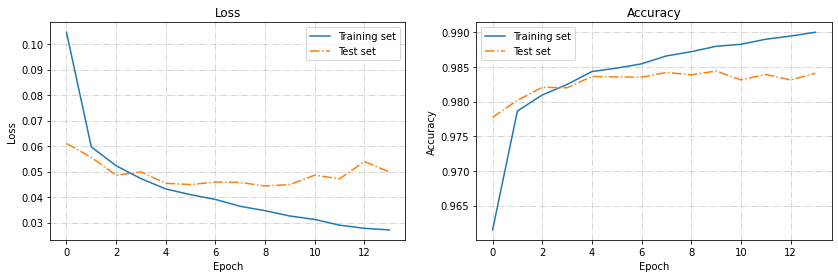

In [ ]:
# Renders the charts for training accuracy and loss.
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='dashdot')
    plt.legend()
    plt.grid(linestyle='dashdot', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='dashdot')
    plt.legend()
    plt.grid(linestyle='dashdot', linewidth=1, alpha=0.5)

    plt.show()
render_training_history(history)

In [ ]:
train_loss, train_accuracy = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)

print('Train loss: ', '{:.2f}'.format(train_loss))
print('Train accuracy: ', '{:.2f}'.format(train_accuracy))

Train loss:  0.04
Train accuracy:  0.98


# **Predicting Samples**

True Case:  candle
Prediction:  cake


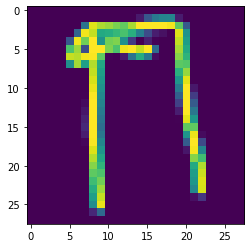

In [ ]:
class_names = ['cake', 'camera', 'candle']

# model predict
y_predict = np.argmax(model.predict(val_X), axis = 1)

# true labels
y_true = list(map(int, val_y))

#get the indices of the bad labels 
bad_labels = np.argwhere((y_true == y_predict) == False).squeeze()

#choose a random index with incorrect label 
idx1 = np.random.choice(bad_labels)

print('True Case: ',class_names[y_true[idx1]])
print('Prediction: ',class_names[y_predict[idx1]])
plt.imshow(val_X[idx1].squeeze())



False Case:  candle
Prediction:  candle


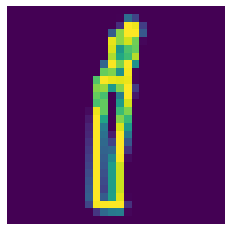

In [ ]:
#get the indices of the good labels 
good_labels = np.argwhere((y_true == y_predict) == True).squeeze()

#choose a random index with correct label 
idx2 = np.random.choice(good_labels)

print('False Case: ',class_names[y_true[idx2]])
print('Prediction: ',class_names[y_predict[idx2]])
plt.imshow(val_X[idx2].squeeze())

plt.axis('off')
plt.show()